In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.integrate import odeint
from IPython.display import HTML

%matplotlib inline

# A Projectile in flight

We've previously solved the differential equation for a projectile in flight; now we're going to animate the output. As a reminder, here's the derivative function that we will integrate:

In [2]:
def projectile_rhs(r, t, b=1.0, c=1.0, m=1.0):
    x,y,vx,vy = r
    vsq = vx**2 + vy**2
    vmag = np.sqrt(vsq)
    
    ax = (-b*vx - c*vsq*vx/vmag)/m
    ay = -9.8 + (-b*vy - c*vsq*vy/vmag)/m
    
    return vx,vy,ax,ay

And the necessary setup.

In [3]:
times = np.linspace(0, 0.85, 1000)
ic = (0,0,10,10)

A call to `odeint` gives us our results...

In [4]:
result = odeint(projectile_rhs, ic, times)

... which we can plot.

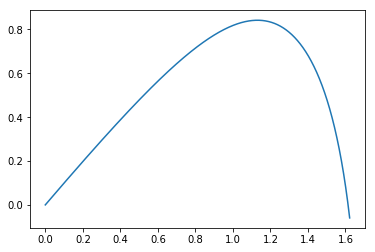

In [5]:
plt.plot(result[:,0], result[:,1])

To make this more dynamic, we will switch to an animation. As a first pass through, let's just plot the location of the projectile as it moves through its trajectory.

In [6]:
# set up our data for the animation
times = np.linspace(0, 0.85, 1000)
ic = (0,0,10,10)
result = odeint(projectile_rhs, ic, times)
x = result[:,0]
y = result[:,1]
vx = result[:,2]
vy = result[:,3]

# create the figure and get the background set up
fig, ax = plt.subplots(figsize=(10,10))

# limits come from what we know about the static plot, but they could have
# come from the data, as well.
ax.set_xlim(0,1.8)
ax.set_ylim(0,1.0)

# this is a placeholder for the projectile. Note that there isn't
# any data to plot yet.
pointmarker, = ax.plot([], [], "o")

def init():
    # still no data to plot
    pointmarker.set_data([], [])
    
    # the comma is very important here!
    return pointmarker,

def animate(i):
    # update the position of the projectile from data
    pointmarker.set_data(x[i], y[i])
    
    # again, the comma is important!
    return pointmarker,

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=len(times), blit=True, init_func=init, interval=100)

# close the figure
plt.close(fig)

The animation has been created, but we don't see anything yet. To make something we can see, we have to actually render the animation, either by saving it or by turning it into a video we can watch in the browser. If you're going to use the animation in some other context (e.g., put it in a powerpoint presentation, or on the web) then you'll want to save the video:

In [7]:
# save the animation -- best if you're running on your own computer
# though you will have to install ffmpeg
anim.save("Descriptive_title.mp4", fps=30)

If, on the other hand, you just want to see the animation, or if you're going to use a jupyter notebook for your presentation, you can encode it as an html5 video and display it inline.

In [8]:
# display inline -- this takes a bit to compute and load
# the "interval" argument determines the length of the encode
HTML(anim.to_html5_video())

This isn't a great animation, for at least three reasons:
- It's almost entirely white space
- It's easy to lose track of where the projectile has been
- The projectile moves too slowly

The first of these criticisms is at least partly due to the physical content; any display of a projectile will likely show mostly empty space. The other two are relatively easy to fix, however.

We can make the projectile move faster by changing one of the parameters we used when creating the animation. The `interval` parameter indicates how long the animation should take to run, in seconds.

To solve the other problem, let's include a line showing the trajectory the projectile has already covered.

In [9]:
times = np.linspace(0, 0.85, 1000)
ic = (0,0,10,10)
result = odeint(projectile_rhs, ic, times)
x = result[:,0]
y = result[:,1]
vx = result[:,2]
vy = result[:,3]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0,1.8)
ax.set_ylim(0,1.0)
pointmarker, = ax.plot([], [], "o")
traversed, = ax.plot([], [], ":")

def init():
    pointmarker.set_data([], [])
    traversed.set_data([], [])
    return pointmarker, traversed

def animate(i):
    pointmarker.set_data(x[i], y[i])
    traversed.set_data(x[:i], y[:i])
    return pointmarker, traversed

anim = animation.FuncAnimation(fig, animate, frames=len(times), blit=True, init_func=init, interval=10)
plt.close(fig)
HTML(anim.to_html5_video())

That's significantly better, but we can improve even more by

## Adding some annotations

In addition to the position and trajectory, we might want to know some things about the projectile which change over time. For the purposes of this example, we'll add the time and the speed (useful for thinking about terminal velocity). We should also add a title and some axis labels.

In [10]:
times = np.linspace(0, 0.85, 1000)
ic = (0,0,10,10)
result = odeint(projectile_rhs, ic, times)
x = result[:,0]
y = result[:,1]
vx = result[:,2]
vy = result[:,3]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0,1.8)
ax.set_ylim(0,1.0)
pointmarker, = ax.plot([], [], "o")
traversed, = ax.plot([], [], ":")

time_label = plt.text(1.0, 0.05, "")
speed_label = plt.text(1.0, 0.08, "")
title = plt.title("A projectile with both linear and quadratic drag")
xlab = plt.xlabel("x (m)")
ylab = plt.ylabel("y (m)")
def init():
    pointmarker.set_data([], [])
    traversed.set_data([], [])
    time_label.set_text("")
    speed_label.set_text("")
    return pointmarker, traversed, time_label

def animate(i):
    pointmarker.set_data(x[i], y[i])
    traversed.set_data(x[:i], y[:i])
    time_label.set_text("t = {:6.3f} s".format(times[i]))
    v = np.sqrt(vx[i]**2 + vy[i]**2)
    speed_label.set_text("v = {:6.3f} m/s".format(v))
    return pointmarker, traversed, time_label, speed_label

anim = animation.FuncAnimation(fig, animate, frames=len(times), blit=True, init_func=init, interval=10)
plt.close(fig)
HTML(anim.to_html5_video())

That works, but I'd like the annotations to be more visually prominent.  I'm going to move them to the top of the plot and increase their size and weight. Since I want to apply the same styles to both labels, I'll build a `fontdict` to hold font information, and then use it when creating both labels.

In [13]:
times = np.linspace(0, 0.85, 1000)
ic = (0,0,10,10)
result = odeint(projectile_rhs, ic, times)
x = result[:,0]
y = result[:,1]
vx = result[:,2]
vy = result[:,3]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0,1.8)
ax.set_ylim(0,1.0)
pointmarker, = ax.plot([], [], "o")
traversed, = ax.plot([], [], ":")
title = plt.title("A projectile with both linear and quadratic drag")
xlab = plt.xlabel("x (m)")
ylab = plt.ylabel("y (m)")

fontdict={"size":14,
          "weight":600,
          "name": "Gill Sans MT"}

time_label = plt.text(1.4, 0.95, "", fontdict=fontdict)
speed_label = plt.text(0.2, 0.95, "", fontdict=fontdict)

def init():
    pointmarker.set_data([], [])
    traversed.set_data([], [])
    time_label.set_text("")
    speed_label.set_text("")
    return pointmarker, traversed, time_label

def animate(i):
    pointmarker.set_data(x[i], y[i])
    traversed.set_data(x[:i], y[:i])
    time_label.`("t = {:6.3f} s".format(times[i]))
    v = np.sqrt(vx[i]**2 + vy[i]**2)
    speed_label.set_text("v = {:6.3f} m/s".format(v))
    return pointmarker, traversed, time_label, speed_label

anim = animation.FuncAnimation(fig, animate, frames=len(times), blit=True, init_func=init, interval=10)
plt.close(fig)
HTML(anim.to_html5_video())

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Optimum sizes and weights of annotations depend on a number of factors, but the single most important is whether the animation will be viewed on a monitor or on a projection screen. For still plots, you would have to include papers and posters in the list of possible venues, as well. In general, text needs to be much bigger if the end result will be viewed on a projection screen than if it is to be viewed on a monitor, since the latter is generally much closer to the viewer's face.